# **Initialization**

In [ ]:
# import the necessary libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib import colorbar
from matplotlib.ticker import PercentFormatter
from IPython.core.pylabtools import figsize
from google.colab import files
import matplotlib.ticker as mtick
from scipy.stats import norm
from scipy.optimize import curve_fit
import trackpy as tp
import skimage
from skimage.io import imread
import plotly.graph_objects as go

from google.colab import drive

In [ ]:
# define file path in Google Drive
file_path="file_path.csv"

# open file
drive.mount('/content/gdrive')
open(file_path).read()

# **Functions**

In [ ]:
# define a function to retain only the beads that were successfully tracked for the whole duration of the timelapse video (361 frames for 30 min at 0.2 Hz)
# cut to an arbitrary number of beads
# zero the trajectories, meaning each trajectory starts from the origin (0,0)
# convert from px to microns - the ratio depends on the microscope lens resolution

def data_preparation (file_path, num_beads, num_frames, micron_pixel_ratio, drift_correction):

  # making dataframe
  data = pd.read_csv(file_path)

  # if drift correction is activated
  if drift_correction:
    data.rename(columns={'Trajectory': 'particle', 'Frame': 'frame'}, inplace=True)

    # compute drift and subtract
    drift = tp.compute_drift(data, 10) # Save good drift curves.
    corrected_traj = tp.subtract_drift(data, drift)
    corrected_traj.reset_index(drop = True, inplace = True)
    corrected_traj= corrected_traj.sort_values(by = ['particle', 'frame'])
    corrected_traj.rename(columns={'particle': 'Trajectory', 'frame': 'Frame'}, inplace=True)
    data=corrected_traj


  # create a numpy array with only the columns of interest

  array=data[['Trajectory','Frame','x','y']].to_numpy(dtype=object)  #For a mix of numeric and non-numeric types, the output array will have object dtype.

  rows, columns = array.shape  # this gives the # rows and columns of the array
  num_init=array[rows-1,0]

  print(f"The number of beads tracked in ImageJ is {num_init}.")

  # retain only the beads with all 361 frames

  # count n. frames for each bead
  count_frames={}   # associative array/dictionary composed of a collection of (key, value) pairs, such that each possible key appears at most once in the collection.

  for i in array[:,0]:
    if i in count_frames:
        count_frames[i] +=1
    else:
        count_frames[i] =1

  #print(count_frames)   # for diagnostic

  maxframes=num_frames
  filtered=[]

  for n in count_frames.keys():       # dictionary.keys() gives the list of keys/items in the dictionary; in our case, it's the list of PARTICLE #
    if count_frames[n]==maxframes:
      filtered.append(n)

  #print(filtered)  # (for diagnostic) it lists particle# that have the whole set of 361 frames

  num_filt=len(filtered)
  print(f"The number of particles that have the whole set of {num_frames} frames is {num_filt}.")

  # create a new array with only the beads having 361 frames
  filter_arr=[]   # Create empty array with True or False

  for element in range (0,rows):

    if array[element,0] in filtered:
        filter_arr.append(True)
    else:
        filter_arr.append(False)

  newarray=array[filter_arr]

  # use only a certain number of beads

  cut_frames=num_beads*num_frames     # e.g. 108300 is the n. of frames for the first 300 beads
  cut_array=newarray[0:cut_frames,:]
  #print(cut_array) #for diagnostic
  tot=len(cut_array)

  # zeroing the trajectories so that they all start from the center of the plot
  zero_arr=np.zeros(cut_array.shape)
  zero_arr[:,0]=cut_array[:,0]
  zero_arr[:,1]=cut_array[:,1]


  # zero, convert to microns

  for element in range(0,tot):
    if cut_array[element,1]==0:     # if this is the 1st frame for a bead
      start=element
      deltax=0-cut_array[element,2] # x distance from the origin
      deltay=0-cut_array[element,3] # y distance from the origin

    zero_arr[element,2]=(cut_array[element,2]+deltax)*micron_pixel_ratio  # change x
    zero_arr[element,3]=(cut_array[element,3]+deltay)*micron_pixel_ratio  # change y

  return zero_arr

In [ ]:
# define function to generate medusa plot
# the input array must have 4 columns in the order 'Trajectory','Frame','x','y' (automatic if the data_preparation function is used)

def medusa_plot (zero_arr, x_scale,y_scale, xtick_step, ytick_step, cbar_step, num_frames):
  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)
  frame_list=zero_arr[:,1]
  start_frame=min(frame_list)
  end_frame=start_frame+num_frames-1

  # fig settings
  frame_i=np.arange(0,num_frames*5/60,5/60)  # assign the time to the frame#
  fig, ax = plt.subplots(figsize=(12,10))
  plt.axis([-x_scale,x_scale,-y_scale,y_scale])

  # Create a continuous norm to map from data points to colors
  norm = plt.Normalize(frame_i.min(), frame_i.max())

  # plot

  for element in range(0,tot):
    if zero_arr[element,1]==start_frame:     # if this is the 1st frame for a bead
      start=element

    if zero_arr[element,1]==end_frame:
      x=zero_arr[start:element,2]
      y=zero_arr[start:element,3]
      points = np.array([x, y]).T.reshape(-1, 1, 2)
      segments = np.concatenate([points[:-1], points[1:]], axis=1)

      trajectory = LineCollection(segments, cmap="jet", norm=norm, linewidth=4)
      line = ax.add_collection(trajectory)

      #set the colour according to the time frame data
      trajectory.set_array(frame_i)

  cbar_min=min(frame_i)
  cbar_max=max(frame_i)
  cbar=fig.colorbar(trajectory, ax=ax,ticks=np.arange(cbar_min, cbar_max+cbar_step, cbar_step))
  plt.title(f"Motors n={num_beads}", fontsize=24)
  cbar.set_label("Time (min)",fontsize=28)
  cbar.ax.tick_params(labelsize=24)

  plt.xlabel("x position (μm)", fontsize=28)
  plt.ylabel("y position (μm)", fontsize=28)
  ax.set_xticks(np.arange(-x_scale, x_scale+xtick_step, xtick_step))
  plt.setp(ax.get_xticklabels(), fontsize=24)
  ax.set_yticks(np.arange(-y_scale, y_scale+ytick_step, ytick_step))
  plt.setp(ax.get_yticklabels(), fontsize=24)

  plt.grid()
  plt.show()

The output should look like the following plot. Each line is one motor trajectory and is color-coded based on time according to the color bar on the right. The trajectories are overlaid in the same diagram and they all start from the origin (0,0).



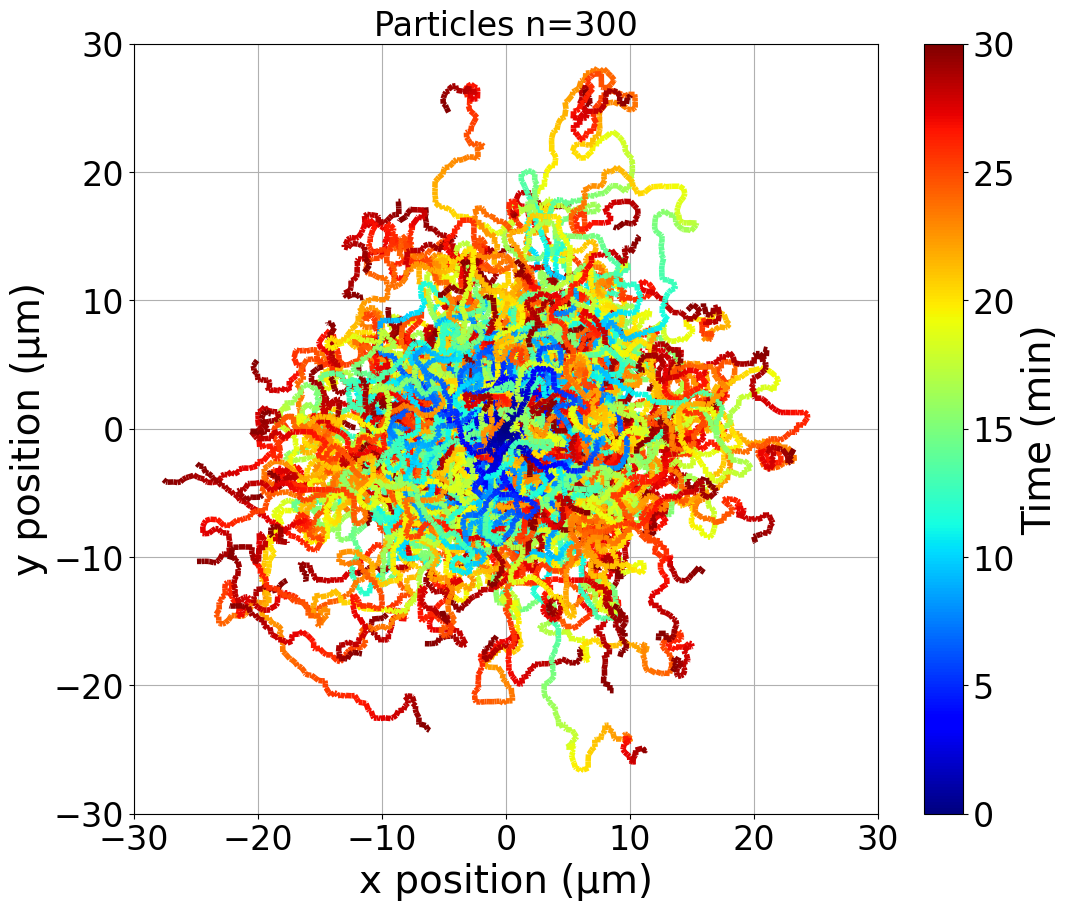

In [ ]:
# distance travelled function and plotting function

def distance_traveled (zero_arr, num_frames):
  distance=[]

  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)

  for element in range(0,tot):
    if zero_arr[element,1]==0:     # 1st frame for a bead
     d=0

    else:
      delta=np.sqrt((zero_arr[element,2] - zero_arr[element-1,2])**2 + (zero_arr[element,3] - zero_arr[element-1,3])**2)
      d=d+delta

    if zero_arr[element,1]==num_frames-1:   # last frame for a bead
      distance.append(d)

  return distance

#############################################################################################

def plot_distance_traveled (distance):    #input array with distance travelled for each bead
  # count n. beads based on the input array
  num_beads=int(len(distance))
  mean=np.average(distance, axis=0)

  print(f"The mean distance traveled is {round(mean,3)} μm")

  fig, ax = plt.subplots(figsize=(9,8))

  ax = sns.boxplot(y=distance,palette="Greens_r",saturation=0.65, width=0.4, linewidth=2,notch=True)
  sns.swarmplot(y=distance,marker="o", alpha=0.7,color=".25")
  plt.ylabel("Distance Traveled (μm)", fontsize=20)
  ax.set_title(f'Particle Displacement n={num_beads}', fontsize=20)
  plt.setp(ax.get_yticklabels(), fontsize=16)
  #ax.set(ylim=(0, 10))
  ax.autoscale()
  plt.grid()

In [ ]:
# net displacement function and plotting function

def net_displacement (zero_arr, num_frames):

  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)

  net_displ=[]

  for element in range(0,tot):
    if zero_arr[element,1]==0:     # 1st frame for a bead
      initial_x=zero_arr[element,2]
      initial_y=zero_arr[element,3]

    if zero_arr[element,1]==num_frames-1:   # last frame for a bead
      final_x=zero_arr[element,2]
      final_y=zero_arr[element,3]
      net_d=np.sqrt((final_x - initial_x)**2 + (final_y - initial_y)**2)
      net_displ.append(net_d)

  return net_displ

#############################################################################################

def plot_net_displacement (net_displ):    #input array with distance travelled for each bead
  # count n. beads based on the input array
  num_beads=int(len(net_displ))
  mean=np. average(net_displ, axis=0)

  print(f"The mean net displacement is {round(mean,3)} μm")

  fig, ax = plt.subplots(figsize=(9,8))

  ax = sns.boxplot(y=net_displ,palette="Blues",saturation=0.65, width=0.4, linewidth=2,notch=True)
  sns.swarmplot(y=net_displ, marker="o", alpha=0.7,color=".25")
  plt.ylabel('Net displacement (μm)', fontsize=20)
  plt.setp(ax.get_yticklabels(), fontsize=16)
  ax.set_title(f'Particle Displacement n={num_beads}', fontsize=20)
  #ax.set(ylim=(-1, 10))
  ax.autoscale()
  plt.grid()

The output should look like the following box plot, where each dot represent the net displacement value of an individual motor particle.

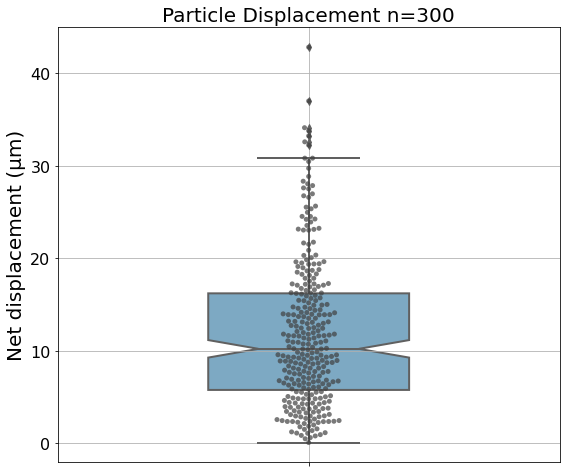

In [ ]:
# net displacement as a function of time
# frame rate=0.2 Hz (frame interval=5 s)

def net_displacement_vs_time (zero_arr, num_frames):

  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)
  time=np.linspace(0,(num_frames-1)*5/60,num_frames)  # time in min

  fig, ax = plt.subplots(figsize=(8,6))
  net_displ_vs_time=[]
  net_displ_vs_time.append(time) # 1st array is time


  for element in range(0,tot):
    if zero_arr[element,1]==0:     # 1st frame for a bead
      net_displ=[]
      initial_x=zero_arr[element,2]
      initial_y=zero_arr[element,3]

    final_x=zero_arr[element,2]
    final_y=zero_arr[element,3]
    d=np.sqrt((final_x - initial_x)**2 + (final_y - initial_y)**2)
    net_displ.append(d)  # add row

    if zero_arr[element,1]==num_frames-1:   # last frame for a bead
      net_displ_vs_time.append(net_displ)
      x=np.linspace(0,(num_frames)*5/60,num_frames)  # time in min
      y=net_displ[:]
      plt.plot (x,y,linewidth=1)

  plt.xlabel("Time (min)",fontsize=20)
  plt.ylabel("Net displacement ($μm$)",fontsize=20)
  plt.setp(ax.get_xticklabels(), fontsize=16)
  plt.setp(ax.get_yticklabels(), fontsize=16)

  return net_displ_vs_time  # the output array requires transposition (swapping of rows and columns)


The output should track the progression of net displacement over the duration of the timelapse video.

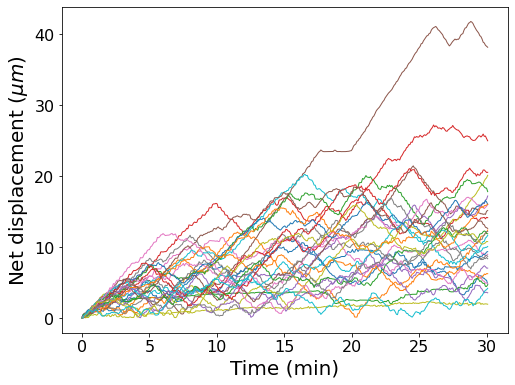

In [ ]:
# function to determine percentage of stalling motors based on change in net displacement

def delta_netdispl (zero_arr, num_frames, interval_min, threshold_micron):

  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)
  interval=interval_min*12 # num of frames corresponding to interval_min

  delta_netdispl=[]

  for element in range(0,tot):
    if zero_arr[element,1]==0:     # 1st frame for a bead
      initial_x=zero_arr[element,2]
      initial_y=zero_arr[element,3]

    if zero_arr[element,1]==(num_frames-interval)-1:   # start of interval from the end
      final_x1=zero_arr[element,2]
      final_y1=zero_arr[element,3]
      net_d1=np.sqrt((final_x1 - initial_x)**2 + (final_y1 - initial_y)**2)

    if zero_arr[element,1]==num_frames-1:   # last frame for a bead
      final_x2=zero_arr[element,2]
      final_y2=zero_arr[element,3]
      net_d2=np.sqrt((final_x2 - initial_x)**2 + (final_y2 - initial_y)**2)
      delta=np.abs(net_d2-net_d1)

      delta_netdispl.append(delta)

  # count num of beads stalling
  stalled=0
  rows=len(delta_netdispl)

  for i in range (0,rows):
    if delta_netdispl[i]<threshold_micron:
      stalled=stalled+1
  print(f"The n. of stalled beads in the last {interval_min} min is {stalled} out of {num_beads} ({round(stalled/num_beads*100,2)}%)")

  return delta_netdispl

In [ ]:
# instantaneous velocity is averaged for each bead
# frame rate=0.2 Hz (frame interval=5 s)

def instantaneous_velocity_xbead (zero_arr, num_frames):

  num_beads=int(len(zero_arr)/num_frames)   # count n. beads based on the input array
  tot=len(zero_arr)

  mean_instav=[]

  for element in range(0,tot):
    if zero_arr[element,1]==0:     # if this is the 1st frame for a bead
      inst_v=[]
      inst_v.append(0)
    else:
      inst_d=np.sqrt((zero_arr[element,2] - zero_arr[element-1,2])**2 + (zero_arr[element,3] - zero_arr[element-1,3])**2)
      v=(inst_d/5*1000)  # nm/s, just remove 1000 to convert to μm/s
      inst_v.append(v)

    if zero_arr[element,1]==num_frames-1:
      mean_instav.append(np.mean(inst_v))

  return mean_instav

In [ ]:
# create alpha value array from selected number of frames
# frame rate=0.2 Hz (frame interval=5 s)

def alpha_value (zero_arr, num_frames, use_frames):
  tot=len(zero_arr)
  num_beads=int(tot/num_frames)
  lagtime= range(1,num_frames)  #expressed in #frames, lag times=5s, 10s, 15s, etc
  lagtime_s=np.linspace(5,num_frames*5,num_frames-1) # lagtime in seconds

  split_arr=[]  # array of particle trajectories (arrays of x, y positions)
  alpha_list=[] # it collects the alpha lists for each particle/trajectory

  for element in range (0,tot):
    if zero_arr[element,1]==0:
      single_traj=zero_arr[element:element+num_frames,:]
      split_arr.append(single_traj)

  for bead in range (0,num_beads):
    one_traj=split_arr[bead]
    msd_1traj=[]       # it contains the msd at each lag time for a single traj
    for i in lagtime:
      sd_list=[]

      for j in range(0,num_frames-i):
        sd=(one_traj[j+i,2]-one_traj[j,2])**2 + (one_traj[j+i,3]-one_traj[j,3])**2 # column 2 contains x coord, col 3 contains y coord
        sd_list.append(sd)

      avg_sd=np.mean(sd_list)  # msd at a lag time for a single traj
      msd_1traj.append(avg_sd)

    x=np.log(lagtime_s[0:use_frames])
    y=np.log(msd_1traj[0:use_frames])

    m, b = np.polyfit(x,y, 1)
    alpha_list.append(m)
  return alpha_list

#############################################################################################

def plot_alpha_value (alpha_list):    #input array with distance travelled for each bead
  # count n. beads based on the input array
  num_beads=int(len(alpha_list))
  mean=np. average(alpha_list, axis=0)

  print(f"The mean alpha value is {round(mean,3)}")

  fig, ax = plt.subplots(figsize=(9,8))

  ax = sns.boxplot(y=alpha_list, palette="Oranges", saturation=0.65, width=0.4, linewidth=2, notch=True)
  sns.swarmplot(y=alpha_list, marker="o", alpha=0.7, color=".25")

  plt.ylabel('Alpha values', fontsize=20)
  plt.setp(ax.get_yticklabels(), fontsize=16)
  ax.set_title(f'n={num_beads}', fontsize=20)
  #ax.set(ylim=(-1, 10))
  ax.autoscale()
  plt.grid()

The output is a box plot where each dot represent the alpha value of an individual motor particle, calculated using the first 20% of the frames of the timelapse video.

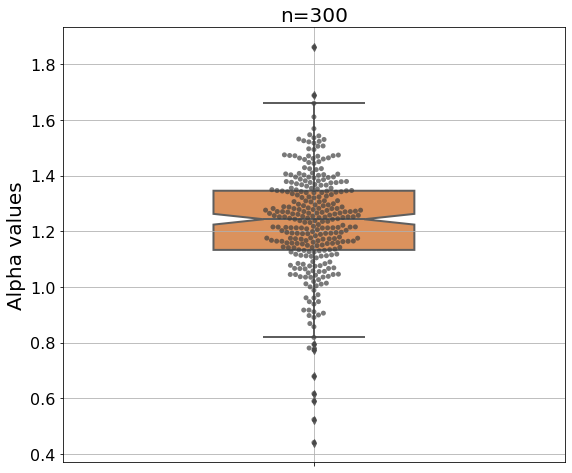